### Requirements & Configurations

In [1]:
import sys  
sys.path.insert(0, '../')

In [2]:
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from catboost import CatBoostClassifier, Pool

from torch import nn
from IPython.display import clear_output
from tqdm import tqdm_notebook, tqdm
from torch.autograd import Variable, grad
from torch.utils.data import DataLoader
from itertools import repeat
from data import *

import torch
import torch.nn.utils.prune as prune
import torch.nn.functional as F

import core.data.rich_utils as rich_utils

import wandb
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy
import os

%matplotlib inline

In [3]:
PARTICLE_TYPE = 'pion'

BATCH_SIZE = 4096
BATCH_SIZE_VAL = 1024
LATENT_DIMENSIONS = 128
NOISE_SIZE = 128
CRAMER_DIM = 512
NUM_LAYERS = 10

CRITIC_ITERATIONS_CONST = 10
TOTAL_ITERATIONS = int(6e4)
VALIDATION_INTERVAL = 10000

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

### Load dataset

In [4]:
from core.data.datasets import ParticleDataset
               

data_train, data_val, scaler = rich_utils.get_merged_typed_dataset(PARTICLE_TYPE, dtype=np.float32)
    
train_loader = torch.utils.data.DataLoader(ParticleDataset(data_train.values),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    pin_memory=True)

val_loader = torch.utils.data.DataLoader(ParticleDataset(data_val.values),
                                                  batch_size=BATCH_SIZE_VAL,
                                                  shuffle=False,
                                                  pin_memory=True)

scaler train sample size: 1500000
scaler n_quantiles: 100000, time = 1.9130511283874512


In [5]:
data_train.head(3)

,RichDLLe,RichDLLk,RichDLLmu,RichDLLp,RichDLLbt,Brunel_P,Brunel_ETA,nTracks_Brunel,probe_sWeight
0,0.482666,0.053458,0.053947,-0.548041,0.269786,0.720969,0.676907,0.097714,0.883707
1,1.486169,-0.762816,1.142220,-0.881954,-0.295823,0.421586,-1.315679,0.559815,0.912539
2,-0.659258,0.147714,-0.582184,0.318019,0.308314,-0.715213,0.341952,1.057633,1.086270


### Load a model 

In [6]:
from torch.quantization import QuantStub, DeQuantStub

class Generator(nn.Module):
    def __init__(self, hidden_size=128, depth=5):
        super(Generator, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(hidden_size + data_train.shape[1] - 1 - rich_utils.y_count, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.LeakyReLU(0.1),
            *[nn.Sequential(
                nn.utils.spectral_norm(nn.Linear(hidden_size, hidden_size)),
                nn.BatchNorm1d(hidden_size),
                nn.LeakyReLU(0.1)) for _ in range(depth)
             ],
            nn.Linear(hidden_size, rich_utils.y_count)
        )
        
    def forward(self, x, noise=None):
        x = torch.cat([x, get_noise(x.shape[0])], dim=1)
        x = self.layers(x)
        return x
    
class Critic(nn.Module):
    def __init__(self, hidden_size=128, depth=5):
        super(Critic, self).__init__()
        self.layers = nn.Sequential(
            nn.utils.spectral_norm(nn.Linear(data_train.shape[1] - 1, hidden_size)),
            nn.LayerNorm(hidden_size),
            nn.LeakyReLU(0.1),
            *[nn.Sequential(
                nn.utils.spectral_norm(nn.Linear(hidden_size, hidden_size)),
                nn.LayerNorm(hidden_size),
                nn.LeakyReLU(0.1))
              for _ in range(depth)],
            nn.utils.spectral_norm(nn.Linear(hidden_size, 1)),
        )

    def forward(self, x):
        return self.layers(x)
    
        
def get_noise(batch_size, mean=0, std=1):
    return torch.zeros(batch_size, LATENT_DIMENSIONS).normal_(mean, std).to(device)

In [132]:
netG = Generator(depth=5).to(device)
netC = Critic(depth=5).to(device)

netC.load_state_dict(torch.load('../weights/C_teacher.pth', map_location={'cuda:3':device}))
netG.load_state_dict(torch.load('../weights/G_teacher.pth', map_location={'cuda:3':device}))

<All keys matched successfully>

In [92]:
def generate(generator, device='cuda', loader=val_loader, iterations=None):
    generator.eval()
    
    dlls = None
    generated = None
    weights = None
    features = None

    with torch.no_grad():
        current_iterations = 0
        for x, weight, real in loader:
            
            weight = weight.detach().cpu().numpy()
            dll = real.detach().cpu().numpy()
            x = x.to(device)
            gen = generator(x).detach().cpu().numpy()
            x = x.detach().cpu().numpy()

            if dlls is None:
                dlls = dll
            else:
                dlls = np.concatenate((dlls, dll))

            if weights is None:
                weights = weight
            else:
                weights = np.concatenate((weights, weight))

            if generated is None:
                generated = gen
            else:
                generated = np.concatenate((generated, gen))
            
            if features is None:
                features = x
            else:
                features = np.concatenate((features, x))
            
            current_iterations += 1
            if iterations is not None and current_iterations > iterations:
                break
    return dlls, generated, weights, features

In [133]:
from core.metrics import hists

def show_rich_dllk(min_eta, max_eta, min_p, max_p):
    inversed_data_train = scaler.inverse_transform(data_train[data_train.columns[:-1]])
    inversed_data_train = pd.DataFrame(inversed_data_train, columns=data_train.columns[:-1])
    inversed_data_train['probe_sWeight'] = data_train['probe_sWeight']
    inversed_data_train.head(3)

    inversed_data_train = inversed_data_train[inversed_data_train['Brunel_ETA'] >= min_eta]
    inversed_data_train = inversed_data_train[inversed_data_train['Brunel_ETA'] <= max_eta]
    inversed_data_train = inversed_data_train[inversed_data_train['Brunel_P'] >= min_p]
    inversed_data_train = inversed_data_train[inversed_data_train['Brunel_P'] <= max_p]
    data_to_generate = scaler.transform(inversed_data_train[inversed_data_train.columns[:-1]].values) 

    weights = inversed_data_train['probe_sWeight'].values
    weights = np.expand_dims(weights, axis=1) 
    data_to_generate = np.hstack((data_to_generate, weights))

    generate_loader = torch.utils.data.DataLoader(ParticleDataset(data_to_generate),
                                                        batch_size=BATCH_SIZE,
                                                        shuffle=False,
                                                        pin_memory=True)

    dlls, generated, weights, features = generate(netG, loader=generate_loader)
    
    y = [1] * dlls.shape[0]
    y.extend(list([0] * generated.shape[0]))
    exp = np.exp(weights)
    y_weights = np.concatenate((exp, exp), axis=0)
    X = np.concatenate((dlls, generated))

    y = np.expand_dims(y, axis=1)
    y_weights = np.expand_dims(y_weights, axis=1)
    y = np.concatenate((y, y_weights), axis=1)

    X = scaler.inverse_transform(np.hstack((X, np.zeros((X.shape[0], 3)))))[:,:5]

    fig, ax = plt.subplots(1, 1, figsize=(7, 7))

    sns.distplot(X[:len(X) // 2, 1], hist_kws={'alpha': 1}, kde=False, bins=50, ax=ax, label="real", norm_hist=True)
    sns.distplot(X[len(X) // 2:, 1], hist_kws={'alpha': 0.5, 'fill': False}, kde=False, bins=50, ax=ax, label="gen", norm_hist=True)

    ax.legend()
    ax.set_xlim([-100, 50])
    ax.set_title(rich_utils.dll_columns[1])

    plt.show()

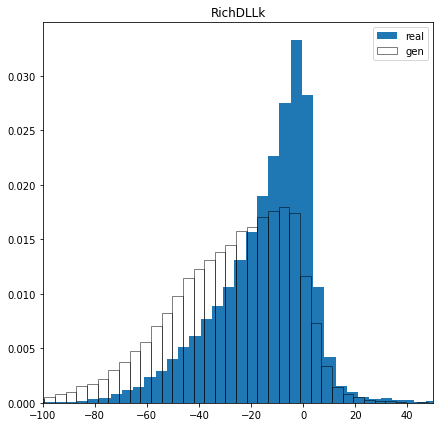

In [135]:
show_rich_dllk(1.91, 2.84, 3.16e+04, 2.5e+05)

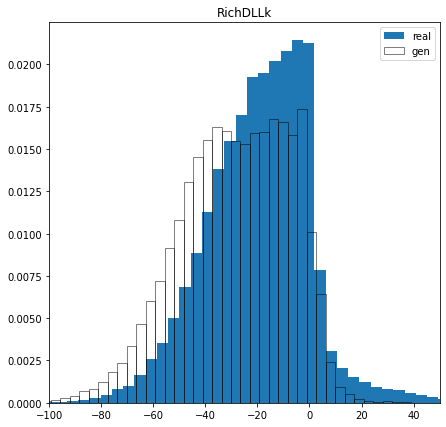

In [136]:
show_rich_dllk(2.84, 3.39, 3.16e+04, 2.5e+05)

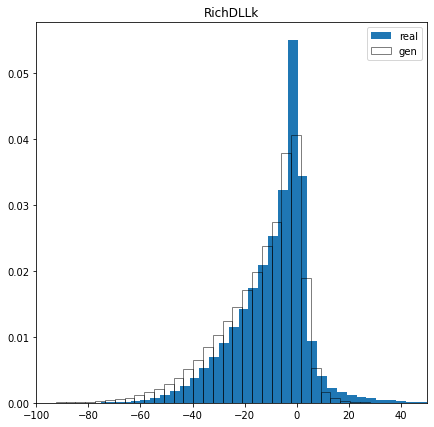

In [137]:
show_rich_dllk(3.39, 4.88, 3.16e+04, 2.5e+05)

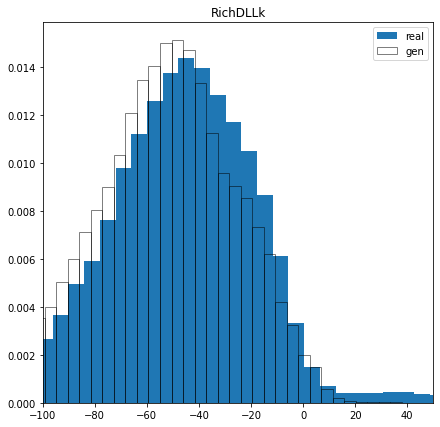

In [138]:
show_rich_dllk(1.91, 2.84, 1.52e+04, 3.16e+04)

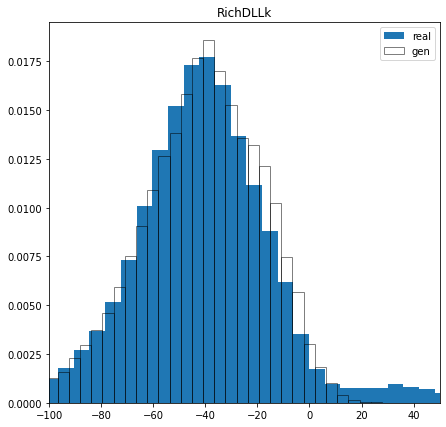

In [139]:
show_rich_dllk(2.84,  3.39, 1.52e+04, 3.16e+04)

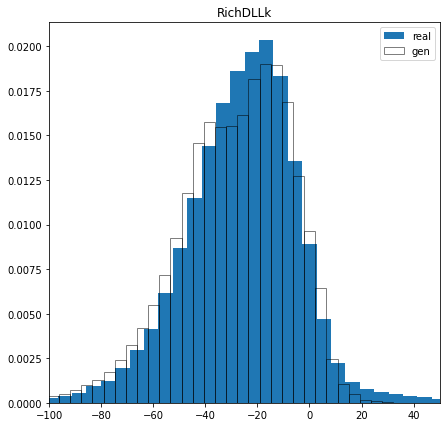

In [141]:
show_rich_dllk(3.39, 4.88, 1.52e+04, 3.16e+04)

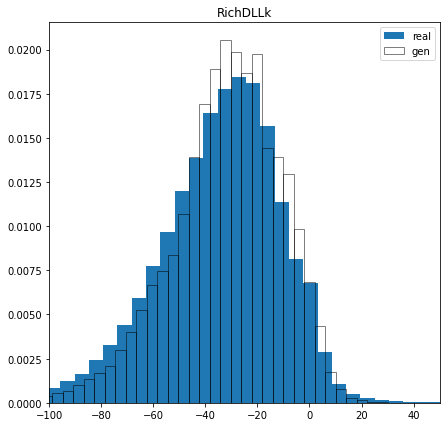

In [142]:
show_rich_dllk(1.91, 2.84, 3.35e+03, 1.52e+04)

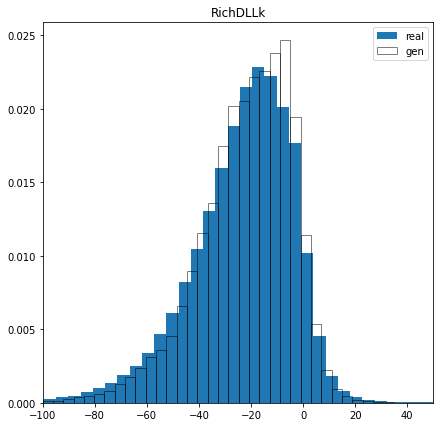

In [143]:
show_rich_dllk(2.84, 3.39, 3.35e+03, 1.52e+04)

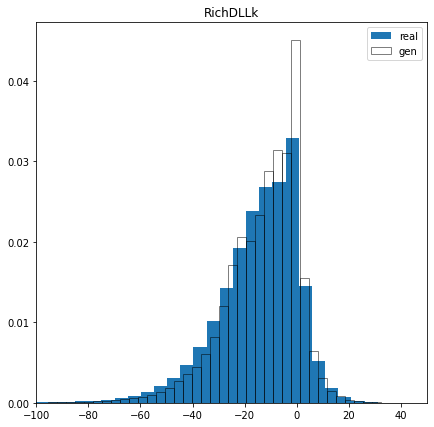

In [144]:
show_rich_dllk(3.39, 4.88, 3.35e+03, 1.52e+04)